In [1]:
import os
import pickle
import numpy 
import random

import matplotlib.pyplot as plt
from pylab import *
from matplotlib import pyplot

import pandas as pd
import os

import tensorflow as tf
from keras.models import Model, Sequential, save_model, load_model
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import h5py



Using TensorFlow backend.


In [17]:
import os 
import pickle
import numpy as np
import random

def preprocess(data_dirs, data_file,name):
    # all_ped_data would be a dictionary with mapping from each ped to their
    # trajectories given by matrix 3 x numPoints with each column
    # in the order x, y, frameId
    # Pedestrians from all datasets are combined
    # Dataset pedestrian indices are stored in dataset_indices
    all_ped_data = {}
    dataset_indices = []
    current_ped = 0
    # For each dataset
    for directory in data_dirs:
        # Define the path to its respective csv file
        file_path = os.path.join(directory,name )

        # Cargar datos desde el archivo csv
        # Los datos son una matriz 4x numTrajPoints
        data = np.genfromtxt(file_path, delimiter=',')
       
        # Obtenga el numero de peatones en el conjunto de datos actual
        #uni = np.unique(data[:,1])    
        numPeds = np.size(np.unique(data[:,1]))
     
        print("El numero de peatones en"+ directory+" es "+str(numPeds))
       
        # Para cada peaton en el conjunto de datos
        for ped in range(1, numPeds+1):
            #Son los datos de la persona ped
            traj = data[ data[:, 1] == ped]
            
            #Esta como (x,y,frame_Id)
            traj = traj[:, [2,3,0]]
            
            #Esta como [[x,...],[y,...],[Frame_Id,..]]
            traj=[list(traj[:,0]),list(traj[:,1]),list(traj[:,2])]
            all_ped_data[current_ped + ped] = np.array(traj)

        # Current dataset done
        dataset_indices.append(current_ped+numPeds)
        current_ped += numPeds

    # Los datos completos son una tupla de todos los datos de peatones y los indices de datos del conjunto de datos.
    complete_data = (all_ped_data, dataset_indices)
    # Almacena los datos completos en el archivo pickle
    f = open(data_file, "wb")
    pickle.dump(complete_data, f, protocol=2)
    f.close()
    return complete_data
    

In [18]:
def load_preprocessed(data_file,seq_length_obs,batch_size):
    
    # cargar los datos
    f = open(data_file, "rb")
    raw_data = pickle.load(f)
    f.close()

    # Obtengo los peatones
    all_ped_data =raw_data[0]
 
    #all_ped_data es el vector {[[],[],[]],...,[[],[],[]]} tantos como pedestrian hayan
    # No usamos dataset_indices por ahora
    # dataset_indices = self.raw_data[1]

    # Construimos data con secuencias(o trayectorias) del largo than seq_length_obs
    data = []
    counter = 0

    # para cada peaton en data
    for ped in all_ped_data:
        
        #ped es un numero entero y va de 1 hasta la cantidad total de pedestrian
        # Extract his trajectory
        traj = all_ped_data[ped]
        
       
        # If the length of the trajectory is greater than seq_length (+2 as we need both source and target data)
        #solo se toman las trajectorias de longitud mayor a seq_length+2
        if traj.shape[1] >= (seq_length_obs+1):
            # TODO: (Improve) Store only the (x,y) coordinates for now
               
            data.append(traj[[0, 1], :].T)
            #print(traj[[0, 1], :].T)
            # Number of batches this datapoint is worth
            #print(traj.shape[1] )
            #print(int(traj.shape[1] / ((seq_length_obs+1))))
            counter += int(traj.shape[1] / ((seq_length_obs+1)))
        
    # Calculate the number of batches (each of batch_size) in the data
    #counter tiene la cantidad de bloques de 8 pasos
        
    num_batches = int(counter /batch_size)
    #cada bache tiene batch_size conjuntos donde cada conjunto tiene datos de length+2
    return data,num_batches

In [76]:
"""
Cuando se va a entrenar con varios dataset, con 4 del siguiente conjunto
"""
data_dirs = ['../data1/ucy/zara/zara02','../data1/ucy/zara/zara01',
             '../data1/ucy/univ','../data1/eth/hotel','../data1/eth/univ']

dim_image =[[720,576],[720,576],[720,576],[720,576],[640,480]]

indice_test=4

image_size = dim_image[indice_test]

datasets = range(5)
datasets= list(datasets)
datasets.remove(indice_test)

used_data_dirs = [data_dirs[x] for x in datasets]
      
#Directorio de datos donde reside el archivo pickle preprocesado
data_dir = '../data1'

# Defina la ruta del archivo en el que deben almacenarse los datos.
data_file = os.path.join(data_dir, "datos_entrenamiento.cpkl")

name = 'pixel_pos.csv'

# If the file doesn't exist already or if forcePreProcess is true
#se usa preprocesscsv para los csv y preprocess para el .txt

#datos tiene todos las trayectorias de todos los peatones 
data_preprocess = preprocess(used_data_dirs, data_file,name)
datos,numero = load_preprocessed(data_file,8,1)


print("El numero de muestras es de "+str(numero))

640
El numero de peatones en../data1/ucy/zara/zara02 es 204
El numero de peatones en../data1/ucy/zara/zara01 es 148
El numero de peatones en../data1/ucy/univ es 434
El numero de peatones en../data1/eth/hotel es 390
El numero de muestras es de 3832


In [49]:
def secuencia(seq_length_obs,data):
    tamano = int(len(data))
    
    X,Y = [],[]
    for j in range(tamano):
        traj = data[j]
        lon = traj.shape[0]-seq_length_obs-1
        for i in range(0,lon+1):
            a = traj[i:(i +seq_length_obs ), :]
            X.append(a)
            b = traj[i+seq_length_obs, :]  
            Y.append(b-a[len(a)-1,:])
    return np.array(X), np.array(Y)

# Datos para entrenamiento

In [40]:
length_obs = 8
trainX,trainY = secuencia(length_obs,datos)

In [41]:
trainY.shape

(30059, 2)

In [42]:
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1],trainX.shape[2]))

In [43]:
data_shape = trainX.shape[1:]
print(data_shape)
import numpy as np
np.shape(trainX)

(8, 2)


(30059, 8, 2)

# Se diseña la red

In [ ]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras import initializers
from datetime import datetime

if 'model' in globals(): del model
model = None
model = Sequential()
model.add(LSTM(9, return_sequences=True, input_shape=data_shape, name='lstm1'))
model.add(LSTM(9, name='lstm2'))
model.add(Dense(2))

In [ ]:
model.summary()

In [ ]:
#,validation_data=(valiX,valiY)
opt = optimizers.RMSprop(lr = 0.006, decay=1e-2)
model.compile( optimizer = opt,loss='logcosh',metrics=['mse'])
history1 = model.fit(trainX, trainY, epochs=80, batch_size=15, verbose=2 )
#,callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=5, verbose=1)])

In [ ]:
history_dict1 = history1.history
history_dict1.keys()

In [ ]:
acc = history1.history['mean_squared_error']
#val_acc = history.history['val_mean_squared_error']
loss = history1.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

# figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b', label='Training loss')
#plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training mse')
#plt.plot(epochs, val_acc, 'g', label='Validation mse')
plt.title('Training mse')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Guardamos los modelos

In [ ]:
#model.save('lstm-ucy-univ.h5')

In [ ]:
#model.save('lstm-eth-hotel.h5')

In [ ]:
#model.save('lstm-ucy-zara-zara01.h5')

In [ ]:
#model.save('lstm-ucy-zara-zara02.h5')

In [ ]:
#model.save('lstm-eth-univ.h5')

# Aqui se carga el modelo con el cual queremos trabajar

In [46]:
modeldxdy = load_model('lstm-eth-univ.h5')#quiere decir que predice las trayectorias  de ucy-hotel

# Para cargar el dataset que es el test

In [58]:

dataset_test=[indice_test]

used_data_dirs = [data_dirs[x] for x in dataset_test]
#Directorio de datos donde reside el archivo pickle preprocesado
data_dir = '../data1'

#Defina la ruta del archivo en el que deben almacenarse los datos.
data_file = os.path.join(data_dir, "datos_limpios_prueba.cpkl")

name ='pixel_pos.csv'
# If the file doesn't exist already or if forcePreProcess is true
#se usa preprocesscsv para los csv y preprocess para el .txt

#print(used_data_dirs)
data1 = preprocess(used_data_dirs, data_file,name)

# la segunda entrada es la suma de obs + pred
test,numero = load_preprocessed(data_file,12,1)#los ultimos dos valores noimportan

El numero de peatones en../data1/eth/univ es 360


# Prediccion

In [59]:
def error_promedio(predicted_traj, true_traj, seq_length_obs):
    
    error = np.zeros(len(true_traj) - seq_length_obs)
    # PARA CADA PUNTO EN LA TRAYECTORIA PREDICHA
    for i in range(seq_length_obs, len(true_traj)):
        # The predicted position
        pred_pos = predicted_traj[i]
        # The true position
        true_pos = true_traj[i]

        # The euclidean distance is the error
        error[i-seq_length_obs] = np.linalg.norm(true_pos - pred_pos)

    # Return the mean error
    return np.mean(error)


In [60]:
def error_desplazamiento_final(predicted_traj, true_traj):
    tam = len(predicted_traj)
    return np.linalg.norm(predicted_traj[tam-1]-true_traj[tam-1])

In [61]:
def secuencia_pred(seq_length_obs,data,seq_length_pred):
    tamano = int(len(data))
    
    X,Y_true = [],[]
    for j in range(tamano):
        traj = data[j]
        lon = traj.shape[0]-seq_length_obs-seq_length_pred
    #lon=data.shape[0]-seq_length_obs-seq_length_pred
        for i in range(0,lon+1):
            a = traj[i:(i +seq_length_obs ), :]
            
            X.append(a)
            
            b = traj[i: (i+seq_length_obs+seq_length_pred), :]
        
            Y_true.append(b)
    return np.array(X),np.array(Y_true)

In [62]:
"""
Esta funcion calcula el error del modelo , al evaluar el conjunto de test
y los resultados estan en coordenadas normalizados
"""


def sample(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_pred(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    total_final = 0.0
    todo = []
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        #print(Y_true[i])
        
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modeldxdy.predict(traj_obsr)
            next_point = traj_obs[len(traj_obs)-1]+predict
                      
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
            
        diff = Y_true[i][seq_length_obs:]-traj_pred[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        
        todo.append(diff)
        total_error += error_promedio(traj_pred , Y_true[i], seq_length_obs)
        total_final += error_desplazamiento_final(traj_pred, Y_true[i]) 
        
        
    error_modelo = total_error/len(X)
    error_fde_modelo = total_final/len(X)
    ade=[t for o in todo for t in o]
    
    print('ADE')
    print(np.mean(ade))
    
    print(error_modelo)
    print('FDE')
    print(error_fde_modelo)
        
    
    

In [82]:
"""
Esta funcion calcula el error del modelo , al evaluar el conjunto de test
y los resultados estan en marco pixeles
"""
def sample_en_pixeles(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_pred(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    total_final = 0.0
    todo = []
    
    
    trayectoria=[]
    verdadero=[]
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modeldxdy.predict(traj_obsr)
            next_point = traj_obs[len(traj_obs)-1]+predict
                      
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
        
        #traj_pre = []
        #traj_tr = []
        #for k in range(len(traj_pred)):
        #    traj_pre.append([640* traj_pred[k,0],480*traj_pred[k,1]])
        #    traj_tr.append([640* Y_true[i][k,0],480*Y_true[i][k,1]])
        
        #traj_pre = np.array(traj_pre)
        #traj_tr = np.array(traj_tr)
        
        traj_pre =  np.column_stack((image_size[0]*traj_pred[:,0],image_size[1]*traj_pred[:,1]))
        traj_tr = np.column_stack((image_size[0]*Y_true[i][:,0],image_size[1]*Y_true[i][:,1]))
        
        trayectoria.append(traj_pre)
        verdadero.append(traj_tr)
        
        # calcular ADE
        diff = traj_tr[seq_length_obs:]-traj_pre[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        todo.append(diff)
        
        total_error += error_promedio(traj_pre ,traj_tr,seq_length_obs)
        total_final += error_desplazamiento_final(traj_pre, traj_tr)
        
    error_modelo = total_error/len(X)
    error_fde_modelo = total_final/len(X)
    ade = [t for o in todo for t in o]
    
    print('ADE')
    print(np.mean(ade))
    print(error_modelo)
    print('FDE')
    print(error_fde_modelo)
    #return trayectoria, verdadero

In [83]:
sample(test, 8, 4)

ADE
0.0294501208384656
0.029450120838465616
FDE
0.04912033061766524


In [84]:
sample_en_pixeles(test,8,4)

ADE
14.907239293213372
14.90723929321336
FDE
24.8391347108852


In [85]:
def secuencia_x_persona(seq_length_obs,data,seq_length_pred):
    tamano = int(len(data))
    X,Y_true = [],[]
    for j in range(tamano):
        traj = data[j]
        X.append(traj[0:seq_length_obs,:])
        Y_true.append(traj[0:seq_length_obs+seq_length_pred,:])
    return np.array(X),np.array(Y_true)

In [86]:
"""
Esta función predice las posiciones futuras de los peatones tomando como observada las primeras Tobs 
posiciones del peaton y los resultados estan normalizados
"""

def sample_x_persona_normalizado(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_x_persona(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    plt.figure(figsize=(18,15))  
    color_names = ["r","crimson" ,"g", "b","c","m","y","lightcoral", "peachpuff","grey","springgreen" ,"fuchsia","violet","teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]
    todo=[]
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modeldxdy.predict(traj_obsr)
            next_point = traj_obs[len(traj_obs)-1]+predict
          
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
        
        diff = Y_true[i][seq_length_obs:]-traj_pred[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        
        todo.append(diff)
     
    
        error_prom = error_promedio(traj_pred ,Y_true[i], seq_length_obs)
        FDE = error_desplazamiento_final(traj_pred , Y_true[i])
        

        print("TRAYECTORIA PREDICHA DEL PEATON ",i+1)
        print(traj_pred)
        print("TRAYECTORIA VERDADERA  ")
        print(Y_true[i])
        print("EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = {:.3f} ".format(error_prom))
        print("ERROR DE DESPLAZAMIENTO FINAL ES ={:.3f}".format(FDE))
                         
        #cpu = random.choice(range(17))
                         
        subplot(1,1,1)
        
        predicha=plt.plot(Y_true[i][:12,0],Y_true[i][:12,1],'*--',color=color_names[19-i])
        predicha=plt.plot(traj_pred[seq_length_obs:(seq_length_obs+seq_length_pred),0],
                                  traj_pred[seq_length_obs:(seq_length_obs+seq_length_pred),1],'o--',color=color_names[i])
        plt.title("Cuatro posiciones predichas con LSTM-DX-DY") 
        plt.xlabel('Coordenada x')
        plt.ylabel('Coordenada y')
        
        
        total_error += error_prom
    error_modelo = total_error/len(X)
    ade=[t for o in todo for t in o]
    
    
    
    print("EL ERROR PROMEDIO DE TODA LA PREDICCIÓN")
    print(error_modelo)
    print('ADE')
    print(np.mean(ade))
    plt.savefig("4prediccion.pdf")
    plt.show()
    
        

In [87]:
"""
Esta función predice las posiciones futuras de los peatones tomando como observada las primeras Tobs 
posiciones del peaton y los resultados estan en marco pixel
"""



def sample_x_persona(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_x_persona(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    plt.figure(figsize=(18,15))  
    color_names = ["r", "g", "b","c","m","y", "peachpuff","grey", "fuchsia","violet",
                   "teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]
    todo=[]
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modeldxdy.predict(traj_obsr)
            next_point = traj_obs[len(traj_obs)-1]+predict
          
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
    
        traj_pre = []
        traj_tr = []
        for k in range(len(traj_pred)):
            traj_pre.append([image_size[0]* traj_pred[k,0],image_size[1]*traj_pred[k,1]])
            traj_tr.append([image_size[0]* Y_true[i][k,0],image_size[1]*Y_true[i][k,1]])
        
        traj_pre=np.array(traj_pre)
        traj_tr=np.array(traj_tr)
        error_prom = error_promedio(traj_pre , traj_tr, seq_length_obs)
        FDE = error_desplazamiento_final(traj_pre , traj_tr)
        
        diff = traj_tr[seq_length_obs:]-traj_pre[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        
        todo.append(diff)
    

        print("TRAYECTORIA PREDICHA DEL PEATON ",i+1)
        print(traj_pre)
        print("TRAYECTORIA VERDADERA  ")
        print(traj_tr)
        print("EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = {:.3f} ".format(error_prom))
        print("ERROR DE DESPLAZAMIENTO FINAL ES ={:.3f}".format(FDE))
                         
        cpu = random.choice(range(17))
                         
        subplot(1,1,1)
        
        predicha=plt.plot(traj_tr[:,0],traj_tr[:,1],'*--',color=color_names[cpu])                
        predicha=plt.plot(traj_pre[seq_length_obs:(seq_length_obs+seq_length_pred),0],
                                  traj_pre[seq_length_obs:(seq_length_obs+seq_length_pred),1],'o--',color=color_names[cpu])
        
        plt.title("Cuatro posiciones predichas con LSTM-DX-DY") 
        plt.xlabel('Coordenada x')
        plt.ylabel('Coordenada y')
        
        
        total_error += error_prom
    error_modelo = total_error/len(X)
    
    ade=[t for o in todo for t in o]
    print("EL ERROR PROMEDIO DE TODA LA PREDICCIÓN")
    print(error_modelo)
    print("Error ADE")
    print(np.mean(ade))
    plt.savefig("trayectoriasdxdy.jpg")
    plt.show()
    
        
    
    

('TRAYECTORIA PREDICHA DEL PEATON ', 1)
[[0.52552    0.95347   ]
 [0.52031    0.86667   ]
 [0.52083    0.82708   ]
 [0.52552    0.77014   ]
 [0.53438    0.73125   ]
 [0.53646    0.68819   ]
 [0.54115    0.64861   ]
 [0.54375    0.61042   ]
 [0.54811285 0.57531333]
 [0.55251406 0.54311145]
 [0.55678808 0.51242187]
 [0.56085233 0.48377515]]
TRAYECTORIA VERDADERA  
[[0.52552 0.95347]
 [0.52031 0.86667]
 [0.52083 0.82708]
 [0.52552 0.77014]
 [0.53438 0.73125]
 [0.53646 0.68819]
 [0.54115 0.64861]
 [0.54375 0.61042]
 [0.54479 0.57708]
 [0.54844 0.54792]
 [0.55313 0.51875]
 [0.55885 0.50139]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.009 
ERROR DE DESPLAZAMIENTO FINAL ES =0.018
('TRAYECTORIA PREDICHA DEL PEATON ', 2)
[[0.55573    0.8875    ]
 [0.56094    0.85625   ]
 [0.56146    0.80694   ]
 [0.55833    0.76319   ]
 [0.55781    0.71875   ]
 [0.55573    0.67986   ]
 [0.55365    0.63958   ]
 [0.55156    0.6       ]
 [0.55056089 0.56725767]
 [0.54906807 0.53525495]
 [0.54745373 0.5049

('TRAYECTORIA PREDICHA DEL PEATON ', 19)
[[0.39896    0.43542   ]
 [0.41146    0.46736   ]
 [0.4125     0.49167   ]
 [0.41979    0.525     ]
 [0.42448    0.55972   ]
 [0.42813    0.6       ]
 [0.4349     0.64097   ]
 [0.44271    0.67847   ]
 [0.44779898 0.70445831]
 [0.45270892 0.73053769]
 [0.45762095 0.75567421]
 [0.46223537 0.77880324]]
TRAYECTORIA VERDADERA  
[[0.39896 0.43542]
 [0.41146 0.46736]
 [0.4125  0.49167]
 [0.41979 0.525  ]
 [0.42448 0.55972]
 [0.42813 0.6    ]
 [0.4349  0.64097]
 [0.44271 0.67847]
 [0.44844 0.71667]
 [0.45417 0.75417]
 [0.46146 0.79306]
 [0.47031 0.83542]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.033 
ERROR DE DESPLAZAMIENTO FINAL ES =0.057
('TRAYECTORIA PREDICHA DEL PEATON ', 20)
[[0.54062    0.92292   ]
 [0.54896    0.86736   ]
 [0.55208    0.82222   ]
 [0.55469    0.77917   ]
 [0.55573    0.73472   ]
 [0.56042    0.69097   ]
 [0.56562    0.64792   ]
 [0.56615    0.60625   ]
 [0.56993543 0.57168036]
 [0.57328672 0.53829723]
 [0.57657252 0.50

IndexError: list index out of range

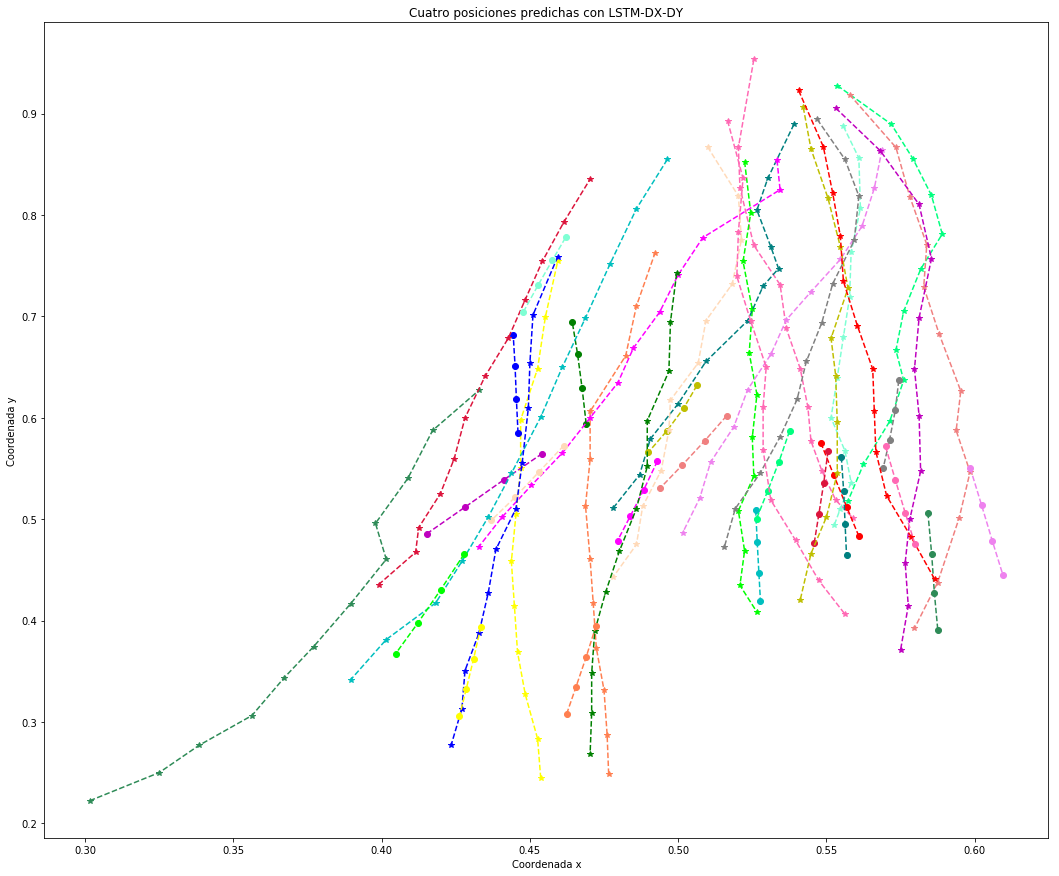

In [88]:
sample_x_persona_normalizado(test,8,4)

('TRAYECTORIA PREDICHA DEL PEATON ', 1)
[[336.3328     457.6656    ]
 [332.9984     416.0016    ]
 [333.3312     396.9984    ]
 [336.3328     369.6672    ]
 [342.0032     351.        ]
 [343.3344     330.3312    ]
 [346.336      311.3328    ]
 [348.         293.0016    ]
 [350.79222369 276.15040013]
 [353.60900092 260.69349477]
 [356.34437132 245.96249977]
 [358.94548941 232.21207121]]
TRAYECTORIA VERDADERA  
[[336.3328 457.6656]
 [332.9984 416.0016]
 [333.3312 396.9984]
 [336.3328 369.6672]
 [342.0032 351.    ]
 [343.3344 330.3312]
 [346.336  311.3328]
 [348.     293.0016]
 [348.6656 276.9984]
 [351.0016 263.0016]
 [354.0032 249.    ]
 [357.664  240.6672]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 4.540 
ERROR DE DESPLAZAMIENTO FINAL ES =8.552
('TRAYECTORIA PREDICHA DEL PEATON ', 2)
[[355.6672     426.        ]
 [359.0016     411.        ]
 [359.3344     387.3312    ]
 [357.3312     366.3312    ]
 [356.9984     345.        ]
 [355.6672     326.3328    ]
 [354.336      306.9984

('TRAYECTORIA PREDICHA DEL PEATON ', 19)
[[255.3344     209.0016    ]
 [263.3344     224.3328    ]
 [264.         236.0016    ]
 [268.6656     252.        ]
 [271.6672     268.6656    ]
 [274.0032     288.        ]
 [278.336      307.6656    ]
 [283.3344     325.6656    ]
 [286.59134919 338.13998997]
 [289.73371083 350.65809279]
 [292.87741    362.72362292]
 [295.83063775 373.82555336]]
TRAYECTORIA VERDADERA  
[[255.3344 209.0016]
 [263.3344 224.3328]
 [264.     236.0016]
 [268.6656 252.    ]
 [271.6672 268.6656]
 [274.0032 288.    ]
 [278.336  307.6656]
 [283.3344 325.6656]
 [287.0016 344.0016]
 [290.6688 362.0016]
 [295.3344 380.6688]
 [300.9984 401.0016]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 15.758 
ERROR DE DESPLAZAMIENTO FINAL ES =27.663
('TRAYECTORIA PREDICHA DEL PEATON ', 20)
[[345.9968     443.0016    ]
 [351.3344     416.3328    ]
 [353.3312     394.6656    ]
 [355.0016     374.0016    ]
 [355.6672     352.6656    ]
 [358.6688     331.6656    ]
 [361.9968     311.

('TRAYECTORIA PREDICHA DEL PEATON ', 34)
[[220.9984     130.3344    ]
 [229.664      146.6688    ]
 [240.         165.9984    ]
 [250.336      183.3312    ]
 [255.3344     202.6656    ]
 [261.9968     224.0016    ]
 [268.3328     242.6688    ]
 [272.9984     265.6656    ]
 [280.35414841 280.24088919]
 [287.07552698 294.9258396 ]
 [293.35174945 309.18437779]
 [299.387342   322.67930537]]
TRAYECTORIA VERDADERA  
[[220.9984 130.3344]
 [229.664  146.6688]
 [240.     165.9984]
 [250.336  183.3312]
 [255.3344 202.6656]
 [261.9968 224.0016]
 [268.3328 242.6688]
 [272.9984 265.6656]
 [277.9968 288.9984]
 [284.     312.3312]
 [289.3312 336.    ]
 [295.0016 362.0016]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 23.356 
ERROR DE DESPLAZAMIENTO FINAL ES =39.566
('TRAYECTORIA PREDICHA DEL PEATON ', 35)
[[232.6656     127.6656    ]
 [242.0032     144.3312    ]
 [251.0016     162.        ]
 [259.3344     180.3312    ]
 [266.6688     200.3328    ]
 [272.9984     222.        ]
 [280.3328     240.

EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 21.495 
ERROR DE DESPLAZAMIENTO FINAL ES =36.742
('TRAYECTORIA PREDICHA DEL PEATON ', 51)
[[342.5024      71.5008    ]
 [344.          84.        ]
 [346.5024     104.832     ]
 [348.4992     123.4992    ]
 [347.6672     144.9984    ]
 [345.1648     165.        ]
 [344.4992     186.        ]
 [343.0016     207.3312    ]
 [342.7509428  223.88826167]
 [341.97719762 240.61167395]
 [340.81533024 256.83266556]
 [339.40447578 272.3436836 ]]
TRAYECTORIA VERDADERA  
[[342.5024  71.5008]
 [344.      84.    ]
 [346.5024 104.832 ]
 [348.4992 123.4992]
 [347.6672 144.9984]
 [345.1648 165.    ]
 [344.4992 186.    ]
 [343.0016 207.3312]
 [343.0016 230.6688]
 [342.5024 255.    ]
 [340.832  279.4992]
 [336.6656 303.6672]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 18.823 
ERROR DE DESPLAZAMIENTO FINAL ES =31.443
('TRAYECTORIA PREDICHA DEL PEATON ', 52)
[[305.3312     398.6688    ]
 [301.4976     372.        ]
 [298.8352     345.4992    ]
 [298.8

('TRAYECTORIA PREDICHA DEL PEATON ', 70)
[[190.336      104.1648    ]
 [204.4992     116.6688    ]
 [219.0016     131.5008    ]
 [232.832      145.5024    ]
 [247.8336     159.6672    ]
 [258.5024     176.5008    ]
 [266.336      196.1664    ]
 [270.5024     216.9984    ]
 [282.21894582 229.01506564]
 [292.79767712 241.68966999]
 [302.64814575 254.45968052]
 [312.10995038 266.91437235]]
TRAYECTORIA VERDADERA  
[[190.336  104.1648]
 [204.4992 116.6688]
 [219.0016 131.5008]
 [232.832  145.5024]
 [247.8336 159.6672]
 [258.5024 176.5008]
 [266.336  196.1664]
 [270.5024 216.9984]
 [275.5008 237.4992]
 [282.6688 259.3344]
 [289.3312 281.832 ]
 [295.5008 305.5008]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 25.904 
ERROR DE DESPLAZAMIENTO FINAL ES =42.009
('TRAYECTORIA PREDICHA DEL PEATON ', 71)
[[336.4992     380.5008    ]
 [341.3312     356.6688    ]
 [344.6656     333.3312    ]
 [348.9984     307.4976    ]
 [353.3312     285.9984    ]
 [355.8336     266.0016    ]
 [358.5024     246.

('TRAYECTORIA PREDICHA DEL PEATON ', 89)
[[439.6672      69.3312    ]
 [421.9968      79.5024    ]
 [406.0032     101.1648    ]
 [396.832      123.6672    ]
 [387.5008     147.        ]
 [379.168      170.5008    ]
 [375.0016     195.4992    ]
 [369.9968     221.5008    ]
 [361.38577419 240.32451426]
 [353.72085469 259.80008756]
 [346.30085009 278.78162657]
 [338.62259584 296.85885702]]
TRAYECTORIA VERDADERA  
[[439.6672  69.3312]
 [421.9968  79.5024]
 [406.0032 101.1648]
 [396.832  123.6672]
 [387.5008 147.    ]
 [379.168  170.5008]
 [375.0016 195.4992]
 [369.9968 221.5008]
 [364.4992 248.832 ]
 [359.5008 277.1664]
 [352.     306.4992]
 [341.3312 335.1648]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 23.515 
ERROR DE DESPLAZAMIENTO FINAL ES =38.402
('TRAYECTORIA PREDICHA DEL PEATON ', 90)
[[282.0032      53.0016    ]
 [283.168       68.3328    ]
 [284.832       82.5024    ]
 [288.4992     101.0016    ]
 [288.832      117.9984    ]
 [288.832      140.5008    ]
 [288.9984     160.

('TRAYECTORIA PREDICHA DEL PEATON ', 108)
[[317.9968     421.8336    ]
 [308.         390.9984    ]
 [298.336      365.3328    ]
 [291.6672     328.6656    ]
 [291.0016     300.        ]
 [286.5024     274.4976    ]
 [280.6656     249.4992    ]
 [275.5008     227.0016    ]
 [270.61284481 207.01879415]
 [266.16694091 188.27031407]
 [261.94453178 170.98758611]
 [257.77124761 155.46129379]]
TRAYECTORIA VERDADERA  
[[317.9968 421.8336]
 [308.     390.9984]
 [298.336  365.3328]
 [291.6672 328.6656]
 [291.0016 300.    ]
 [286.5024 274.4976]
 [280.6656 249.4992]
 [275.5008 227.0016]
 [270.5024 203.832 ]
 [263.0016 183.    ]
 [252.4992 163.5024]
 [240.832  145.5024]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 10.260 
ERROR DE DESPLAZAMIENTO FINAL ES =19.650
('TRAYECTORIA PREDICHA DEL PEATON ', 109)
[[296.          91.5024    ]
 [289.4976     116.0016    ]
 [285.3312     137.6688    ]
 [286.0032     163.5024    ]
 [289.8304     190.4976    ]
 [297.3312     216.3312    ]
 [304.4992     24

('TRAYECTORIA PREDICHA DEL PEATON ', 128)
[[344.9984      83.0016    ]
 [348.832       99.9984    ]
 [354.6688     122.5008    ]
 [352.         144.4992    ]
 [348.832      166.4976    ]
 [344.6656     188.1648    ]
 [341.4976     206.5008    ]
 [338.6688     224.1648    ]
 [336.66337252 241.19340475]
 [333.77892316 257.64295275]
 [330.40316999 273.14247663]
 [326.91679478 287.6303562 ]]
TRAYECTORIA VERDADERA  
[[344.9984  83.0016]
 [348.832   99.9984]
 [354.6688 122.5008]
 [352.     144.4992]
 [348.832  166.4976]
 [344.6656 188.1648]
 [341.4976 206.5008]
 [338.6688 224.1648]
 [339.5008 245.832 ]
 [333.4976 270.4992]
 [328.1664 293.3328]
 [322.336  315.    ]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 16.590 
ERROR DE DESPLAZAMIENTO FINAL ES =27.750
('TRAYECTORIA PREDICHA DEL PEATON ', 129)
[[382.5024      83.0016    ]
 [380.4992     100.8336    ]
 [376.3328     119.1648    ]
 [372.4992     138.4992    ]
 [369.664      156.9984    ]
 [368.832      179.5008    ]
 [365.4976     20

('TRAYECTORIA PREDICHA DEL PEATON ', 148)
[[296.          84.3312    ]
 [296.4992     102.9984    ]
 [299.6672     118.1664    ]
 [299.6672     143.1648    ]
 [301.4976     164.5008    ]
 [304.         185.1648    ]
 [306.5024     206.0016    ]
 [307.5008     228.4992    ]
 [309.39643036 245.20670856]
 [311.23088847 261.8960389 ]
 [312.89465319 278.10495342]
 [314.41659461 293.28899945]]
TRAYECTORIA VERDADERA  
[[296.      84.3312]
 [296.4992 102.9984]
 [299.6672 118.1664]
 [299.6672 143.1648]
 [301.4976 164.5008]
 [304.     185.1648]
 [306.5024 206.0016]
 [307.5008 228.4992]
 [311.3344 250.4976]
 [314.6688 273.8352]
 [316.4992 296.5008]
 [318.1696 321.3312]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 16.274 
ERROR DE DESPLAZAMIENTO FINAL ES =28.292
('TRAYECTORIA PREDICHA DEL PEATON ', 149)
[[356.832      431.1648    ]
 [364.9984     402.        ]
 [370.8352     375.6672    ]
 [371.6672     351.4992    ]
 [371.0016     324.9984    ]
 [370.8352     299.5008    ]
 [369.1648     27

 [348.9984 317.1648]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 14.806 
ERROR DE DESPLAZAMIENTO FINAL ES =23.947
('TRAYECTORIA PREDICHA DEL PEATON ', 168)
[[336.6656      97.6656    ]
 [333.9968     117.4992    ]
 [333.1648     132.168     ]
 [334.8352     150.4992    ]
 [333.9968     167.5008    ]
 [338.5024     186.6672    ]
 [342.6688     204.168     ]
 [343.0016     222.9984    ]
 [344.53050325 237.81044957]
 [346.30286047 252.42476847]
 [347.99490878 266.68557402]
 [349.43556616 280.24726   ]]
TRAYECTORIA VERDADERA  
[[336.6656  97.6656]
 [333.9968 117.4992]
 [333.1648 132.168 ]
 [334.8352 150.4992]
 [333.9968 167.5008]
 [338.5024 186.6672]
 [342.6688 204.168 ]
 [343.0016 222.9984]
 [340.832  241.6656]
 [340.832  260.0016]
 [340.4992 279.4992]
 [340.832  298.8336]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 12.503 
ERROR DE DESPLAZAMIENTO FINAL ES =20.481
('TRAYECTORIA PREDICHA DEL PEATON ', 169)
[[314.6688     113.832     ]
 [314.5024     129.4992    ]
 [314.336   

('TRAYECTORIA PREDICHA DEL PEATON ', 186)
[[337.3312     100.1664    ]
 [334.0032     119.0016    ]
 [332.1664     138.9984    ]
 [332.9984     158.1648    ]
 [334.0032     176.5008    ]
 [336.3328     194.6688    ]
 [343.0016     211.3344    ]
 [348.9984     229.5024    ]
 [351.16936567 244.82707604]
 [354.20230153 259.67221691]
 [357.53798368 273.8400714 ]
 [360.78496101 287.26461782]]
TRAYECTORIA VERDADERA  
[[337.3312 100.1664]
 [334.0032 119.0016]
 [332.1664 138.9984]
 [332.9984 158.1648]
 [334.0032 176.5008]
 [336.3328 194.6688]
 [343.0016 211.3344]
 [348.9984 229.5024]
 [354.1696 247.8336]
 [357.4976 267.8352]
 [357.4976 288.4992]
 [359.168  308.832 ]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 12.334 
ERROR DE DESPLAZAMIENTO FINAL ES =21.628
('TRAYECTORIA PREDICHA DEL PEATON ', 187)
[[356.         419.0016    ]
 [354.8352     392.6688    ]
 [355.6672     362.6688    ]
 [350.0032     341.0016    ]
 [345.9968     315.6672    ]
 [334.336      294.8352    ]
 [325.9968     27

('TRAYECTORIA PREDICHA DEL PEATON ', 205)
[[344.3328     426.8352    ]
 [337.9968     408.9984    ]
 [336.9984     392.0016    ]
 [335.3344     377.0016    ]
 [331.5008     362.0016    ]
 [319.5008     354.8352    ]
 [304.4992     334.8336    ]
 [291.5008     312.        ]
 [283.49306081 300.21698517]
 [273.88846968 288.49551451]
 [263.32652901 277.07430732]
 [252.47275208 266.16779101]]
TRAYECTORIA VERDADERA  
[[344.3328 426.8352]
 [337.9968 408.9984]
 [336.9984 392.0016]
 [335.3344 377.0016]
 [331.5008 362.0016]
 [319.5008 354.8352]
 [304.4992 334.8336]
 [291.5008 312.    ]
 [282.1696 286.4976]
 [273.8304 261.4992]
 [267.5008 239.0016]
 [261.4976 216.8352]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 32.308 
ERROR DE DESPLAZAMIENTO FINAL ES =50.151
('TRAYECTORIA PREDICHA DEL PEATON ', 206)
[[254.1696     174.        ]
 [263.5008     194.5008    ]
 [270.8352     216.168     ]
 [278.336      238.6656    ]
 [284.         259.4976    ]
 [289.8304     282.168     ]
 [297.3312     30

('TRAYECTORIA PREDICHA DEL PEATON ', 225)
[[318.336      444.8352    ]
 [305.4976     418.5024    ]
 [289.9968     395.6688    ]
 [284.1664     370.6656    ]
 [280.4992     346.4976    ]
 [276.3328     321.8352    ]
 [269.664      301.8336    ]
 [264.9984     273.        ]
 [258.703051   256.11294436]
 [253.16643038 239.61190867]
 [248.01701644 223.85118055]
 [242.8614507  209.25021636]]
TRAYECTORIA VERDADERA  
[[318.336  444.8352]
 [305.4976 418.5024]
 [289.9968 395.6688]
 [284.1664 370.6656]
 [280.4992 346.4976]
 [276.3328 321.8352]
 [269.664  301.8336]
 [264.9984 273.    ]
 [262.1696 262.6656]
 [256.3328 237.6672]
 [251.5008 230.0016]
 [247.8336 214.6656]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 6.387 
ERROR DE DESPLAZAMIENTO FINAL ES =7.352
('TRAYECTORIA PREDICHA DEL PEATON ', 226)
[[212.4992     122.0016    ]
 [220.6656     138.3312    ]
 [228.1664     152.5008    ]
 [234.0032     165.9984    ]
 [239.6672     180.6672    ]
 [246.336      196.5024    ]
 [255.5008     210.

('TRAYECTORIA PREDICHA DEL PEATON ', 244)
[[303.168      395.832     ]
 [295.6672     373.3344    ]
 [293.9968     348.4992    ]
 [294.336      323.5008    ]
 [296.832      298.5024    ]
 [297.4976     274.4976    ]
 [296.9984     250.8336    ]
 [293.664      230.0016    ]
 [293.54051944 212.62483916]
 [293.5292792  195.83690545]
 [293.39353796 180.0941374 ]
 [293.18425652 165.60274682]]
TRAYECTORIA VERDADERA  
[[303.168  395.832 ]
 [295.6672 373.3344]
 [293.9968 348.4992]
 [294.336  323.5008]
 [296.832  298.5024]
 [297.4976 274.4976]
 [296.9984 250.8336]
 [293.664  230.0016]
 [288.     210.    ]
 [279.3344 191.1648]
 [272.6656 173.6688]
 [266.5024 155.5008]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 17.826 
ERROR DE DESPLAZAMIENTO FINAL ES =28.530
('TRAYECTORIA PREDICHA DEL PEATON ', 245)
[[212.832      101.1648    ]
 [224.4992     116.5008    ]
 [236.         129.6672    ]
 [246.8352     147.168     ]
 [255.0016     165.        ]
 [262.6688     186.        ]
 [267.6672     20

('TRAYECTORIA PREDICHA DEL PEATON ', 263)
[[313.9968     101.0016    ]
 [310.8352     117.9984    ]
 [310.8352     138.8352    ]
 [308.9984     160.5024    ]
 [308.832      182.3328    ]
 [308.         206.5008    ]
 [304.9984     230.0016    ]
 [303.5008     254.5008    ]
 [302.08275662 272.21526705]
 [300.42824076 289.99577366]
 [298.44913767 307.17547618]
 [296.20246457 323.34917151]]
TRAYECTORIA VERDADERA  
[[313.9968 101.0016]
 [310.8352 117.9984]
 [310.8352 138.8352]
 [308.9984 160.5024]
 [308.832  182.3328]
 [308.     206.5008]
 [304.9984 230.0016]
 [303.5008 254.5008]
 [300.9984 280.3344]
 [297.4976 305.5008]
 [294.6688 331.4976]
 [292.9984 356.5008]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 20.473 
ERROR DE DESPLAZAMIENTO FINAL ES =33.306
('TRAYECTORIA PREDICHA DEL PEATON ', 264)
[[332.4992     101.5008    ]
 [330.6688     122.832     ]
 [328.1664     143.6688    ]
 [327.0016     165.        ]
 [325.8304     186.3312    ]
 [324.9984     210.4992    ]
 [322.5024     23

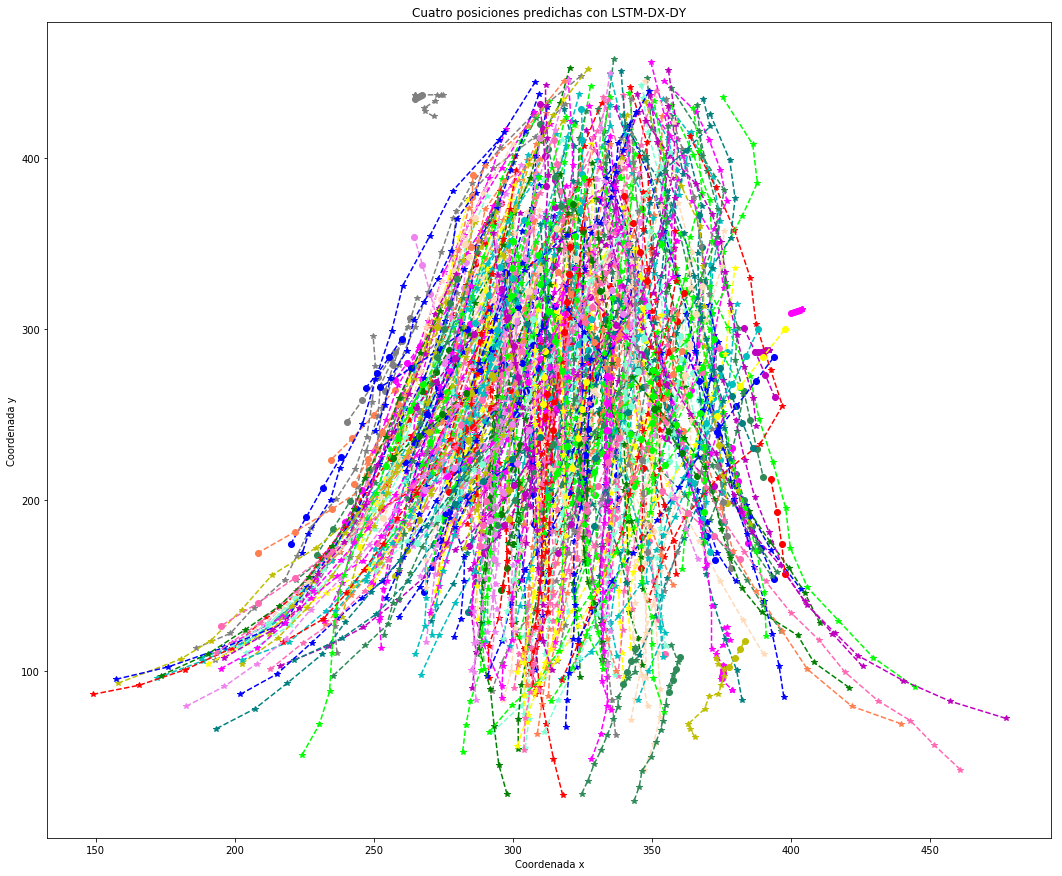

In [89]:
sample_x_persona(test,8,4)